In [2]:
# libraries
import numpy as np
import lightgbm as lgb
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

In [3]:
searched_date='original'
df=pd.read_csv('intermediate_data/preprocessed_spec_iqr1_{}.csv'.format(searched_date))
df=df.drop(df.columns[0],axis=1)
df= df.astype('float')

In [46]:
X = df.drop('price', axis=1).as_matrix()
y = df['price']
indices=df.index

#データをわける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, index_train,index_test = train_test_split(X, y,indices, test_size = 0.1, random_state = 666)

In [47]:
params={'n_estimators':[500,1000], #100,300,500,1000実施して1000
                'learning_rate':[0.05,0.08], 
                'gamma':[0], 
                'subsample':[0.5,0.75,0.1],
                'colsample_bytree':[0.5,1], 
                'max_depth':[6] #6,10,15実施して6
}

xgb_model=xgb.XGBRegressor()
gs = GridSearchCV(xgb_model,params)
gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 1000], 'learning_rate': [0.05, 0.08], 'gamma': [0], 'subsample': [0.5, 0.75, 0.1], 'colsample_bytree': [0.5, 1], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
y_test_pred = gs.predict(X_test)
y_train_pred =gs.predict(X_train)
gs.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 1000,
 'subsample': 0.75}

In [49]:
from sklearn.metrics import mean_squared_error
print('rmse_train=',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('rmse_test=',np.sqrt(mean_squared_error(y_test,y_test_pred)))
from sklearn.metrics import r2_score
print('r2_train=',r2_score(y_train,y_train_pred))
print('r2_test=',r2_score(y_test,y_test_pred))

rmse_train= 25.425871244890015
rmse_test= 355.6521852712316
r2_train= 0.9998509832410581
r2_test= 0.9706130223985144


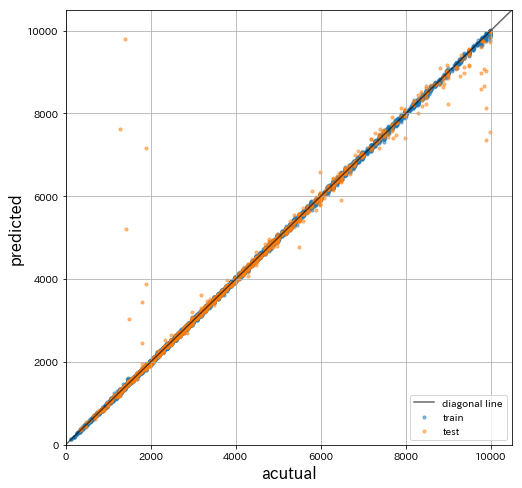

In [50]:
u_lim=10500
l_lim=0
plt.figure(figsize=(8, 8))
plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
plt.scatter(y_train,y_train_pred,label='train',alpha=0.5,s=10)
plt.scatter(y_test,y_test_pred,label='test',alpha=0.5,s=10)
plt.xlim(l_lim,u_lim)
plt.ylim(l_lim,u_lim)
plt.xlabel('acutual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [58]:
#モデルの保存
with open('model/model_xgb_{}.pickle'.format(searched_date),'wb') as f:
    pickle.dump(gs, f)

<function BufferedWriter.close>

In [52]:
dif_train=abs(y_train_pred-y_train)
dif_test=abs(y_test_pred-y_test)
bad_pred_train=dif_train[dif_train>500]
bad_pred_test=dif_test[dif_test>500]
bad_index=list(bad_pred_train.index)
bad_index.extend(list(bad_pred_test.index))
df_bad_pred=df.loc[bad_index,:]

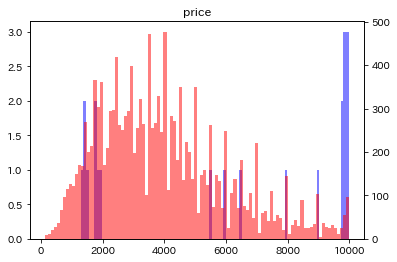

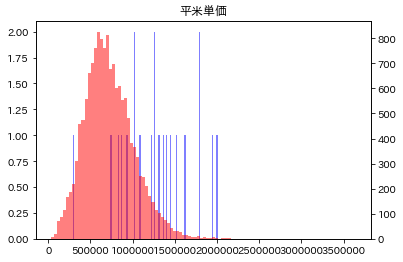

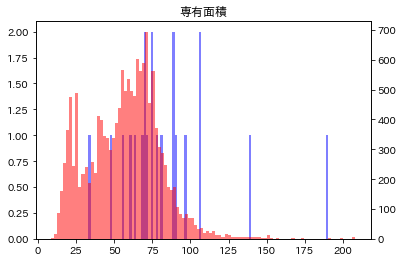

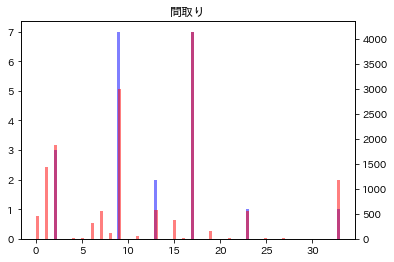

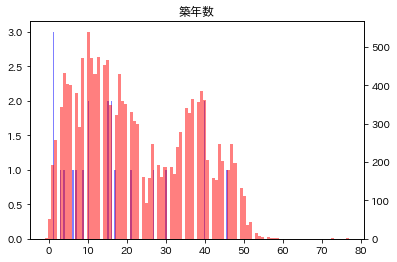

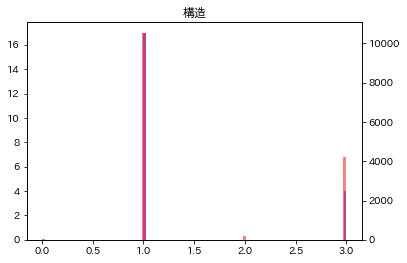

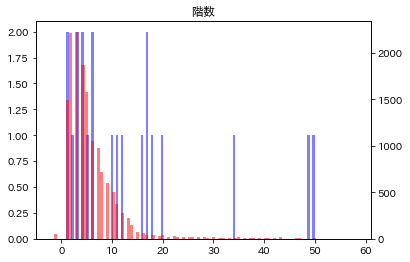

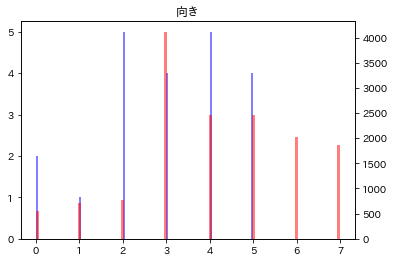

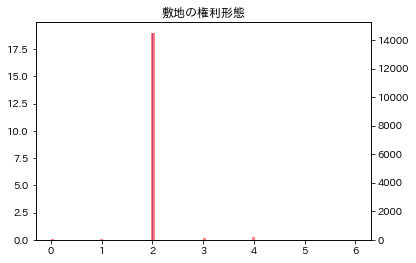

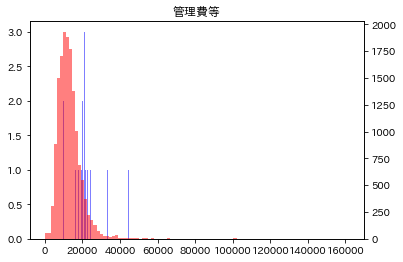

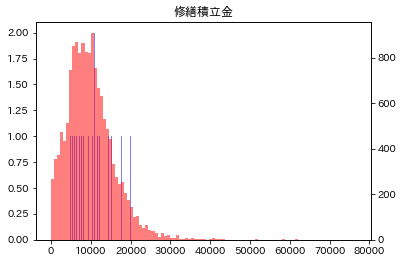

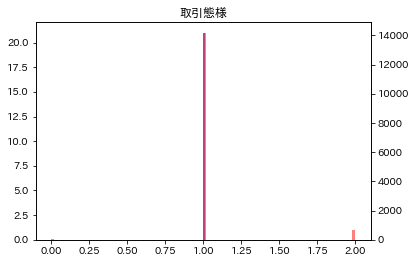

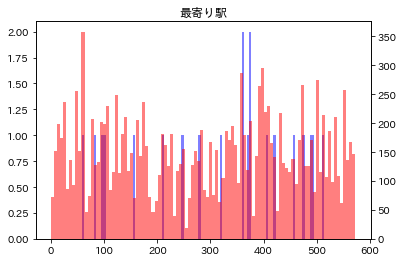

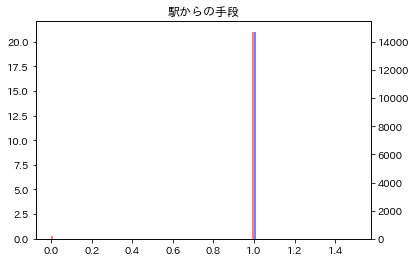

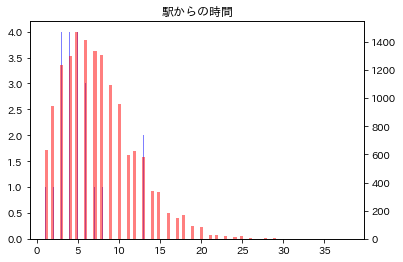

In [53]:
for col in df_bad_pred:
    fig, ax1 = plt.subplots()
    ax1.hist(df_bad_pred[col],bins=100,color='blue', alpha=0.5)
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.hist(df[col],bins=100,color='red', alpha=0.5)
    plt.title(col)
    plt.show()

### 予測を外しているレコードの確認

In [54]:
index=list(index_train)
index.extend(list(index_test))
prediction=list(y_train_pred)
prediction.extend(list(y_test_pred))
df_pred=pd.DataFrame()
df_pred['index']=index
df_pred['prediction']=prediction
df_pred=df_pred.set_index('index')
df_all=df_pred.join(df)

In [55]:
df_all.loc[bad_index,:]

,prediction,price,平米単価,専有面積,間取り,築年数,構造,階数,向き,敷地の権利形態,管理費等,修繕積立金,取引態様,最寄り駅,駅からの手段,駅からの時間
index,,,,,,,,,,,,,,,,
845,7162.137695,1900.0,1798400.0,60.61,9.0,1.0,1.0,4.0,2.0,2.0,20956.0,6061.0,1.0,409.0,1.0,2.0
5148,8589.502930,9780.0,1088800.0,89.83,17.0,15.0,1.0,10.0,4.0,2.0,20000.0,14400.0,1.0,280.0,1.0,1.0
12277,7413.470703,7980.0,829900.0,96.16,17.0,16.0,1.0,1.0,4.0,2.0,9810.0,15390.0,1.0,84.0,1.0,5.0
12134,5915.286621,6480.0,1948900.0,33.25,33.0,4.0,1.0,11.0,5.0,2.0,10800.0,4700.0,1.0,376.0,1.0,4.0
11082,2461.796631,1800.0,1224500.0,88.20,9.0,10.0,1.0,49.0,2.0,2.0,22050.0,17640.0,1.0,514.0,1.0,7.0
5763,8130.754395,9880.0,1257500.0,78.57,17.0,6.0,1.0,20.0,0.0,2.0,25230.0,11000.0,1.0,491.0,1.0,6.0
5035,9074.964844,9850.0,1401800.0,70.27,17.0,21.0,3.0,18.0,4.0,2.0,9900.0,9350.0,1.0,320.0,1.0,5.0
3552,7559.068848,9980.0,936900.0,106.53,9.0,40.0,3.0,6.0,4.0,3.0,21206.0,28511.0,1.0,363.0,1.0,3.0
11736,9026.042969,9900.0,1791900.0,55.25,9.0,46.0,1.0,4.0,4.0,2.0,16400.0,11700.0,1.0,156.0,1.0,4.0


### 予測結果の出力

In [56]:
df_all.to_csv('intermediate_data/prediction_xgboost_{}.csv'.format(searched_date))